In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit

from lib.simdata_i3 import I3SimHandlerFtr
from lib.plotting import plot_event, adjust_plot_1d
from lib.geo import center_track_pos_and_time_based_on_data

from lib.network import get_network_eval_v_fn

from dom_track_eval import get_eval_network_doms_and_track
from likelihood_spe import get_neg_c_triple_gamma_llh
from likelihood_spe import get_llh_and_grad_fs_for_iminuit_migrad

from palettable.cubehelix import Cubehelix
cx =Cubehelix.make(start=0.3, rotation=-0.5, n=16, reverse=False, gamma=1.0,
                           max_light=1.0,max_sat=0.5, min_sat=1.4).get_mpl_colormap()

In [2]:
# Get network and eval logic.
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco/data/network')
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v)

# Get likelihoods
neg_llh, neg_llh_grad = get_llh_and_grad_fs_for_iminuit_migrad(eval_network_doms_and_track)

muon energy: 2.0 TeV
n_doms 97


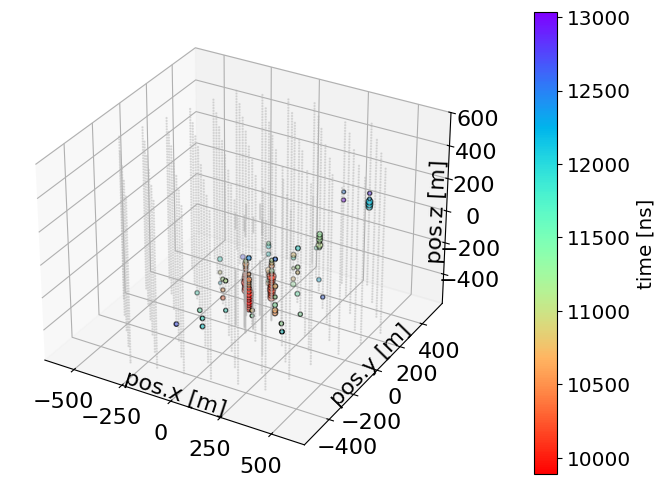

In [3]:
# Event Index.
event_index = 1

# Get an IceCube event.
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandlerFtr(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

print("n_doms", len(event_data))

# Produce and save an event view.
plot_event(event_data, geo=sim_handler.geo)

In [4]:
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

print("old track vertex:", track_pos)
centered_track_pos, centered_track_time = center_track_pos_and_time_based_on_data(event_data, track_pos, track_time, track_src)
print("new track vertex:", centered_track_pos)

# Create some n_photons from qtot (by rounding up).
n_photons = np.round(event_data['charge'].to_numpy()+0.5)

# Combine into single data tensor for fitting.
fitting_event_data = jnp.column_stack([
                                        jnp.array(event_data[['x', 'y', 'z', 'time']].to_numpy()),
                                        jnp.array(n_photons)
                                   ])

old track vertex: [ -57.58777311  104.94960582 -459.58699572]
new track vertex: [  79.52905078  241.90677754 -291.78433739]


In [5]:
f_prime = lambda x: neg_llh(x, centered_track_time, fitting_event_data)
grad_prime = lambda x: neg_llh_grad(x, centered_track_time, fitting_event_data)

x0 = jnp.concatenate([track_src, centered_track_pos])
m = Minuit(f_prime, x0, grad=grad_prime)
m.errordef = Minuit.LIKELIHOOD
m.limits = ((0.0, np.pi), (0.0, 2.0 * np.pi), (-500.0, 500.0),  (-500.0, 500.0),  (-500.0, 500.0))
m.strategy = 0
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1353                       │         Nfcn = 37, Ngrad = 7         │
│ EDM = 6.47e-06 (Goal: 0.0001)    │            time = 4.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  2.2893   │  0.0020   │            │            │    0    │ 3.14159 │       │
│ 1 │ x1   │   3.919   │   0.006   │            │            │    0    │ 6.28319 │       │
│ 2 │ x2   │   79.8    │    0.7    │            │            │  -500   │   500   │       │
│ 3 │ x3   │   242.1   │    0.6    │            │            │  -500   │   500   │       │
│ 4 │ x4   │  -291.1   │    0.4    │            │            │  -500   │   500   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4 │
├────┼───────────────────────────────────────────────────┤
│ x0 │   4.1e-06      2e-6    346e-6    403e-6   -119e-6 │
│ x1 │      2e-6  3.47e-05  3.013e-3 -0.854e-3  1.485e-3 │
│ x2 │    346e-6  3.013e-3     0.502      -0.2      0.16 │
│ x3 │    403e-6 -0.854e-3      -0.2     0.397     -0.02 │
│ x4 │   -119e-6  1.485e-3      0.16     -0.02     0.176 │
└────┴───────────────────────────────────────────────────┘

In [7]:
print(np.rad2deg(meta['spline_mpe_zenith']-track_src[0]))
print(np.rad2deg(meta['spline_mpe_azimuth']-track_src[1]))

0.47835798562202686
-6.762578161498366


In [8]:
smpe_track_pos = jnp.array([meta['spline_mpe_pos_x'], meta['spline_mpe_pos_y'], meta['spline_mpe_pos_z']])
smpe_track_time = meta['spline_mpe_time']
smpe_track_zenith = meta['spline_mpe_zenith']
smpe_track_azimuth = meta['spline_mpe_azimuth']
smpe_track_src = jnp.array([track_zenith, track_azimuth])

print("old track vertex:", smpe_track_pos)
smpe_centered_track_pos, smpe_centered_track_time = center_track_pos_and_time_based_on_data(event_data, 
                                                                                            smpe_track_pos, 
                                                                                            smpe_track_time, 
                                                                                            smpe_track_src)
print("new track vertex:", smpe_centered_track_pos)

old track vertex: [ -14.95262743  151.04664187 -404.81947557]
new track vertex: [  77.78463717  243.6759277  -291.32822712]


In [9]:
f_prime = lambda x: neg_llh(x, smpe_centered_track_time, fitting_event_data)
grad_prime = lambda x: neg_llh_grad(x, smpe_centered_track_time, fitting_event_data)

x0 = jnp.concatenate([smpe_track_src, smpe_centered_track_pos])
m = Minuit(f_prime, x0, grad=grad_prime)
m.errordef = Minuit.LIKELIHOOD
m.limits = ((0.0, np.pi), (0.0, 2.0 * np.pi), (-500.0, 500.0),  (-500.0, 500.0),  (-500.0, 500.0))
m.strategy = 0
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1352                       │        Nfcn = 49, Ngrad = 10         │
│ EDM = 5.95e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   2.293   │   0.004   │            │            │    0    │ 3.14159 │       │
│ 1 │ x1   │   3.922   │   0.006   │            │            │    0    │ 6.28319 │       │
│ 2 │ x2   │   79.8    │    0.6    │            │            │  -500   │   500   │       │
│ 3 │ x3   │   241.8   │    0.6    │            │            │  -500   │   500   │       │
│ 4 │ x4   │  -290.6   │    0.5    │            │            │  -500   │   500   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4 │
├────┼───────────────────────────────────────────────────┤
│ x0 │  1.27e-05  0.010e-3  0.643e-3  0.057e-3  0.734e-3 │
│ x1 │  0.010e-3  3.38e-05  2.418e-3 -1.314e-3  2.422e-3 │
│ x2 │  0.643e-3  2.418e-3      0.39     -0.24      0.22 │
│ x3 │  0.057e-3 -1.314e-3     -0.24     0.331     -0.02 │
│ x4 │  0.734e-3  2.422e-3      0.22     -0.02      0.25 │
└────┴───────────────────────────────────────────────────┘

In [12]:
def GreatCircleDistance(azi_1, zen_1, azi_2, zen_2):
        ra_1 = azi_1
        ra_2 = azi_2
        dec_1 = np.pi/2.0 - zen_1
        dec_2 = np.pi/2.0 - zen_2
        '''Compute the great circle distance between two events'''
        '''All coordinates must be given in radians'''
        delta_dec = np.abs(dec_1 - dec_2)
        delta_ra = np.abs(ra_1 - ra_2)
        x = (np.sin(delta_dec / 2.))**2. + np.cos(dec_1) *\
            np.cos(dec_2) * (np.sin(delta_ra / 2.))**2.
        return 2. * np.arcsin(np.sqrt(x))

print(np.rad2deg(GreatCircleDistance(m.values[1], m.values[0], track_src[1], track_src[0])))

0.5343860875252834


In [17]:
for i in range(3):
    print(smpe_centered_track_pos[i]-centered_track_pos[i])

-1.7444136085952806
1.7691501658558195
0.45611026870034266


In [54]:
# todo future: replace naive draw in zenith, azimuth by spherical draw from sphere to avoid issues at poles.
# e.g. use this: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/VonMisesFisher

n_seeds = 20
seed = 0
key = jax.random.key(seed)

key, subkey = jax.random.split(key)
rvals =  jax.random.normal(subkey, (n_seeds, 5))

seed_zenith = smpe_track_src[0] + np.deg2rad(1) * rvals[:, 0]
seed_zenith = jnp.clip(seed_zenith, 0.0, jnp.pi)

seed_azimuth = smpe_track_src[1] + np.deg2rad(1) * rvals[:, 1]
seed_azimuth = jnp.clip(seed_azimuth, 0.0, 2.0*jnp.pi)

seed_pos = smpe_track_pos + 5.0 * rvals[:, 2:]

random_seeds = jnp.column_stack([seed_zenith, seed_azimuth, seed_pos])
random_seeds = jnp.concatenate([jnp.concatenate([smpe_track_src, smpe_track_pos]).reshape((1,5)), random_seeds], axis=0)

In [55]:
f_prime = lambda x: neg_llh(x, smpe_centered_track_time, fitting_event_data)
grad_prime = lambda x: neg_llh_grad(x, smpe_centered_track_time, fitting_event_data)


In [56]:
def run_seeds(x0):
    logls = []
    directions = []
    for x0 in random_seeds:
        m = Minuit(f_prime, x0, grad=grad_prime)
        m.errordef = Minuit.LIKELIHOOD
        m.limits = ((0.0, np.pi), (0.0, 2.0 * np.pi), (-500.0, 500.0),  (-500.0, 500.0),  (-500.0, 500.0))
        m.strategy = 0
        m.migrad()
        logls.append(m.fval)
        directions.append([m.values[0], m.values[1]])

    return np.column_stack([logls, directions])

In [57]:
%timeit run_seeds(random_seeds)

7.8 s ± 25.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
result = run_seeds(x0)
logls = result[:, 0]
directions = result[:, 1:]

In [59]:
print(logls)

[1351.85489057 1493.79590185 1607.36896174 1587.05328447 1351.85489033
 1595.68113509 1601.65567263 1655.20380368 1603.14536683 1359.54364337
 1359.54364435 1359.70641509 1387.20656661 1606.57365762 1359.70641636
 1353.16593824 1359.54369656 1588.96184063 1361.58306869 1359.54364377
 1615.6830531 ]


In [106]:
print(np.rad2deg(GreatCircleDistance(directions[:, 1], directions[:,0], track_src[1], track_src[0]))[np.argsort(logls)])

[  1.06434212   4.93452759   4.93438553   4.93462356   4.26604993
   4.27320167  13.84871235  49.1121409  129.58576647  88.91482824]


In [49]:
# And do a minimization.
@jax.jit
def minimize_bfgs(x0, track_time, data):
    result = optimize.minimize(neg_llh, 
                             x0, 
                             args=(track_time,
                                   data), 
                             method="BFGS", 
                             options={'gtol':1.e-5})
    
    return result.fun, result.x

In [50]:
x0 = jnp.concatenate([track_src, centered_track_pos])
result_bfgs = minimize_bfgs(x0, centered_track_time, fitting_event_data)
print(result_bfgs)

(Array(1353.55739198, dtype=float64), Array([   2.2968379 ,    3.91781153,   79.43321023,  242.04588412,
       -290.85049186], dtype=float64))


In [51]:
%timeit minimize_bfgs(x0, centered_track_time, fitting_event_data)

30.7 ms ± 33.2 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [52]:
x0 = jnp.concatenate([smpe_track_src, smpe_centered_track_pos])
result_bfgs = minimize_bfgs(x0, smpe_centered_track_time, fitting_event_data)
print(result_bfgs)

(Array(1352.86596198, dtype=float64), Array([   2.296194  ,    3.92057333,   79.67823945,  241.73151388,
       -290.90168179], dtype=float64))


In [53]:
%timeit minimize_bfgs(x0, smpe_centered_track_time, fitting_event_data)

90.2 ms ± 39.2 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
shotgun_w_bfgs = jax.jit(jax.vmap(minimize_bfgs, (0, None, None), (0, 0)))

In [25]:
logls, results = shotgun_w_bfgs(random_seeds, smpe_centered_track_time, fitting_event_data)

In [29]:
print(logls)
print(np.rad2deg(results[:, :2]))
print(results[:, 2:])

[27086.06569625 26944.41811918 25361.55158371  1724.91333208
 20761.56267317  6376.73884646 22303.70151803 27599.00157017
  1530.94058638 11233.70672149  1674.92092613]
[[  134.61377703   224.90648468]
 [  139.09715154   226.65135432]
 [19441.85649701 19411.53945322]
 [  105.35381661   181.75704374]
 [  163.75428654   203.47307425]
 [  131.81000783   228.60371414]
 [  153.18844913   221.68330264]
 [  137.81942622   247.55235864]
 [  136.78362806   219.2864131 ]
 [  114.11282632   244.44160749]
 [  104.67106367   211.41527964]]
[[ -14.95226672  151.04680385 -404.81783277]
 [ -14.72626247  165.72071014 -388.88323184]
 [  44.02580528  150.99884205 -313.45059892]
 [ 383.87649727  312.54291775 -272.51244009]
 [ 108.22080174  164.27656449 -310.22026173]
 [  53.83331314  282.53634394 -314.86996733]
 [  47.93430635  213.99426015 -378.02075568]
 [ -26.58610663  159.94557423 -402.08490379]
 [ 319.41803161  338.70843869 -206.61505545]
 [   4.21763654  168.52254689 -376.51790136]
 [ 335.24967488  

In [76]:
%timeit shotgun_w_bfgs(random_seeds, smpe_centered_track_time, fitting_event_data)

9.28 s ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
import jaxopt

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [14]:
solver = jaxopt.LBFGSB(fun=neg_llh, 
                        maxiter=500, 
                        jit=True,
                        tol=0.1)

solve = jax.jit(solver.run)
bounds = (jnp.array([0.0, 0.0, -500.0, -500.0, -500.0]), jnp.array([jnp.pi, jnp.pi*2.0, 500.0, 500.0, 500.0]))

In [15]:
def run_jaxopt():
    with HiddenPrints():
        x0 = jnp.concatenate([track_src, centered_track_pos])
        result = solve(x0, bounds, centered_track_time, fitting_event_data)
    return result

In [16]:
print(run_jaxopt())

OptStep(params=Array([   2.2931266 ,    3.92194937,   79.77400528,  241.84733346,
       -290.62441081], dtype=float64), state=LbfgsbState(iter_num=Array(56, dtype=int64, weak_type=True), value=Array(1351.8548895, dtype=float64), grad=Array([ 0.02573371, -0.08938915,  0.00211034,  0.00130362, -0.00065021],      dtype=float64), stepsize=Array(0.89970403, dtype=float64), error=Array(0.08938915, dtype=float64), s_history=Array([[ 6.91499384e-07, -3.57892618e-06, -4.08157536e-04,
         3.51028079e-04, -2.34923434e-04],
       [-2.33698699e-07, -1.62021403e-06, -4.43113086e-05,
        -1.29853306e-04, -1.91147196e-04],
       [-2.25464156e-07, -4.25417187e-06, -2.07072314e-04,
        -3.51125193e-04, -5.72035721e-04],
       [-2.40183071e-07, -7.60232284e-07, -1.75916767e-04,
         1.57260919e-04, -5.79701831e-05],
       [-5.57437415e-07,  1.15517082e-07, -8.52977048e-05,
        -7.28651807e-06, -4.00523391e-05],
       [ 1.26163672e-06,  7.13406224e-05,  1.30568492e-02,
        -

In [87]:
%timeit run_jaxopt()

10.4 s ± 124 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
